In [1]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

plt.rcParams["figure.figsize"]=20,20

# Data Importing

In [2]:
import pandas as pd
from joblib import load

file = load('data_clean_sm_pst_till03month_minute.z')
train_ts = file['train']
val_ts = file['val']
test_ts = file['test']

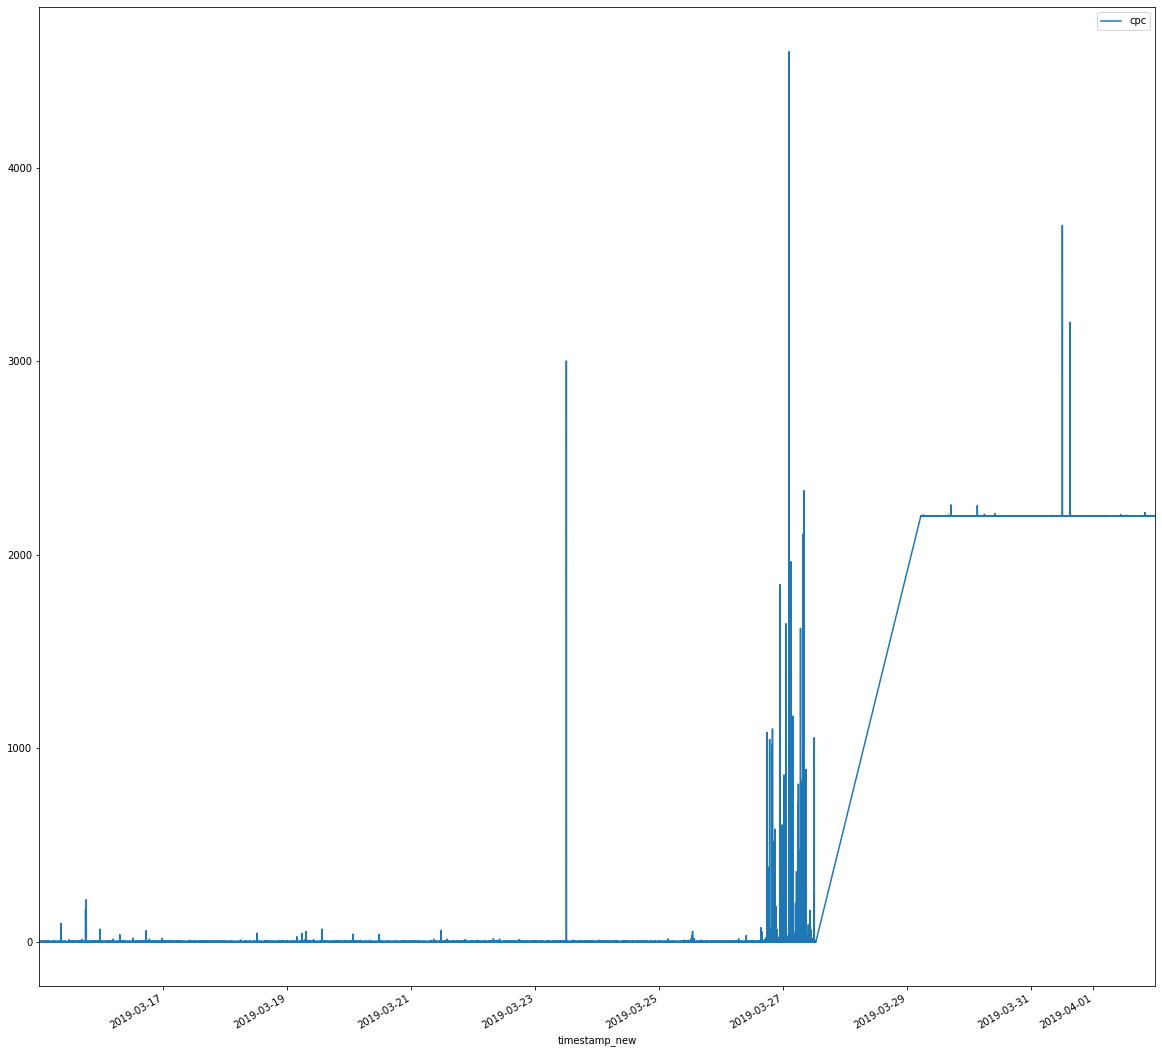

In [5]:
#df1 = pd.read_pickle('custom_data_variation_data.pickle')
# load pickle as DF
df = pd.read_pickle("../custom_data_variation_data_02.pickle")
ts = df.loc[:,['diskio_serviceTime']]
ts.rename(columns={'diskio_serviceTime':'cpc'},inplace=True)
#ts = df.loc[:'2019-03-27 10:00',['diskio_serviceTime']]
ts.sort_index(ascending=True, inplace=True)

#train_ts = train_ts.resample('1T').mean()
#train_ts.fillna(0,inplace=True)
#train_ts = train_ts.drop_duplicates(subset='cpc', keep='last')

ts.plot()

In [6]:
train_ts = ts[:'2019-03-25']
val_ts = ts['2019-03-25':'2019-03-26']
test_ts = ts['2019-03-26':]
print(len(train_ts),len(val_ts),len(test_ts))

1141816 207360 550104


# Preprocessing
Similar to other machine learning approaches, the time-series must be transformed to a supervised learning dataset with an input feature vector/matrix and a target output vector/matrix. There are however some differences specific to neural networks, mainly:
* **Stationarity**: De-trending and de-seasonalizing are not necessarily required for neural network (NN) models. The NN model is the most similar to statistical linear regression methods in comparison with other machine learning approaches. The main advantage over statistical linear regression is that NNs expand the linear mathematical model to capture nonlinear components as well. Thus some users argue that their NN models should be left to learn trends in the time-series on their own, while others argue that statistical decomposition increases model performance.
* **3D input**: Specifically with recurrent neural network methods, the input should be reshaped to a 3 domensional matrix for representing: samples x time-steps x features
* **Normalization:** It has been proven that neural networks are more efficient when the data are normalized. This is because the initial weights are set very close to zero. In this exercise, normalizaiton is ignored. 

In line with the observations from the auto-correlation analysis, transform the data shape to include:
* Periodic cycle of 24 time steps
* Correlations up to 2 lagged cycles
* correlations up to 3 lagged time-steps

In [48]:
'''
import numpy as np

#train_ts_processed = train_ts.to_frame()
train_ts_processed = train_ts[:5].copy()#pd.DataFrame(train_ts[:5].copy())
train_ts_processed['cpc'] = np.log(train_ts_processed.cpc)
for l in [1,2,3,24,48]:
    train_ts_processed['lag-{}'.format(l)] = train_ts_processed['cpc'].shift(periods=l)
#train_ts_processed.dropna(inplace=True, axis=0)
train_ts_processed.fillna(0.0,inplace=True)
train_ts_processed["hour"] = train_ts_processed.index.hour
train_ts_processed["weekday"] = train_ts_processed.index.weekday
train_ts_processed['is_weekend'] = train_ts_processed.weekday.isin([5,6])*1
train_ts_processed
'''

'\nimport numpy as np\n\n#train_ts_processed = train_ts.to_frame()\ntrain_ts_processed = train_ts[:5].copy()#pd.DataFrame(train_ts[:5].copy())\ntrain_ts_processed[\'cpc\'] = np.log(train_ts_processed.cpc)\nfor l in [1,2,3,24,48]:\n    train_ts_processed[\'lag-{}\'.format(l)] = train_ts_processed[\'cpc\'].shift(periods=l)\n#train_ts_processed.dropna(inplace=True, axis=0)\ntrain_ts_processed.fillna(0.0,inplace=True)\ntrain_ts_processed["hour"] = train_ts_processed.index.hour\ntrain_ts_processed["weekday"] = train_ts_processed.index.weekday\ntrain_ts_processed[\'is_weekend\'] = train_ts_processed.weekday.isin([5,6])*1\ntrain_ts_processed\n'

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train_ts[['cpc']])
train_ts['cpc'] = scaler.transform(train_ts[['cpc']])
val_ts['cpc'] = scaler.transform(val_ts[['cpc']])
test_ts['cpc'] = scaler.transform(test_ts[['cpc']])

/home/smartopsai/achyuta/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/smartopsai/achyuta/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/smartopsai/achyuta/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [ ]:
#model.add(LSTM[Float](8, returnSequences = true, inputShape = inputShape))
#model.add(Dropout[Float](0.2))
#model.add(LSTM[Float](32, returnSequences = true))
#model.add(Dropout[Float](0.2))
#model.add(LSTM[Float](15, returnSequences = false))
#model.add(Dropout[Float](0.2))
#model.add(Dense[Float](outputDim = 1))

In [4]:
#train_ts_processed = train_ts.to_frame()
train_ts_processed = pd.DataFrame(train_ts.copy())
#train_ts_processed['cpc'] = np.log(train_ts_processed.cpc)

#new_feature_cols_lag = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,48]
#new_feature_cols_lag = [1,2,3,4,5,6] #woirked
#new_feature_cols_lag = [1,2,3,4,5,6,7,8,9,10,11,12]
new_feature_cols_lag = [i for i in range(1,30)]
len_feature_lag = len(new_feature_cols_lag)#+3
for l in new_feature_cols_lag:
    train_ts_processed['lag-{}'.format(l)] = train_ts_processed['cpc'].shift(periods=l)
#train_ts_processed.dropna(inplace=True, axis=0)
train_ts_processed.fillna(0.0,inplace=True)
#train_ts_processed["hour"] = train_ts_processed.index.hour
#train_ts_processed["weekday"] = train_ts_processed.index.weekday
#train_ts_processed['is_weekend'] = train_ts_processed.weekday.isin([5,6])*1

y = train_ts_processed['cpc'].values
X = train_ts_processed.drop('cpc', axis=1).values.reshape(train_ts_processed.shape[0], len_feature_lag, 1)

#X = scaler.fit_transform(train_ts_processed.drop('cpc', axis=1))
#X = X.reshape(train_ts_processed.shape[0], len_feature_lag, 1)
#y = scaler.transform(y)

# Take useful feature and standardize them
#min_max_scaler = preprocessing.StandardScaler()
#X = min_max_scaler.fit_transform(train_ts_processed)
#X = pd.DataFrame(X)
# reduce to 2 importants features
#pca = PCA(n_components=2)
#X = pca.fit_transform(X)
# standardize these 2 new features
#min_max_scaler = preprocessing.StandardScaler()
#X = min_max_scaler.fit_transform(X)
#X = X.reshape(train_ts_processed.shape[0], len_feature_lag, 1)
#X = pd.DataFrame(X)
print('feature matrix:\n',X)
print('Target vector:\n',y.reshape(-1,1))

feature matrix:
 [[[-6.70790894e+01]
  [-6.48084341e+01]
  [-6.27537802e+01]
  ...
  [-3.97040748e+01]
  [-3.92168706e+01]
  [-3.87471206e+01]]

 [[-1.86433040e+00]
  [-6.48084341e+01]
  [-6.27537802e+01]
  ...
  [-3.97040748e+01]
  [-3.92168706e+01]
  [-3.87471206e+01]]

 [[-2.34018162e+00]
  [-1.80021265e+00]
  [-6.27537802e+01]
  ...
  [-3.97040748e+01]
  [-3.92168706e+01]
  [-3.87471206e+01]]

 ...

 [[ 2.16883413e+00]
  [ 2.13491901e+00]
  [ 5.88651543e-02]
  ...
  [ 2.69748399e-01]
  [ 3.00673666e-01]
  [ 3.58988237e-01]]

 [[ 8.47426950e-01]
  [ 2.09648999e+00]
  [ 2.06827443e+00]
  ...
  [ 1.78155351e-01]
  [ 2.67070312e-01]
  [ 2.97693395e-01]]

 [[ 7.59038510e-01]
  [ 8.19792545e-01]
  [ 2.03106314e+00]
  ...
  [ 4.13680332e-01]
  [ 1.76599744e-01]
  [ 2.64492023e-01]]]
Target vector:
 [[204.95      ]
 [203.45454545]
 [203.75757576]
 ...
 [213.47222222]
 [213.19444444]
 [212.94444444]]


In [29]:
#select and standardize data
data_n = train_ts.copy()#df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
#min_max_scaler = preprocessing.StandardScaler()
#np_scaled = min_max_scaler.fit_transform(data_n)
#data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 10000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ].cpc.as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ].cpc.as_matrix()

/home/smartopsai/achyuta/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/smartopsai/achyuta/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/home/smartopsai/achyuta/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/smartopsai/achyuta/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [30]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
X = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y = y_train[-X.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", X.shape)
print("y_train", y.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (53027, 50, 1)
y_train (53077,)
x_test (53027,)
y_test (10000,)


In [18]:
train_ts_processed.tail()

,cpc,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7,lag-8,lag-9,lag-10,lag-11,lag-12
timestamp_new,,,,,,,,,,,,,
2019-03-13 05:00:00,217.750000,211.000000,211.694444,211.972222,212.000000,212.000000,216.263889,213.902778,211.638889,212.333333,211.694444,211.666667,211.819444
2019-03-13 05:01:00,217.625000,217.750000,211.000000,211.694444,211.972222,212.000000,212.000000,216.263889,213.902778,211.638889,212.333333,211.694444,211.666667
2019-03-13 05:02:00,213.472222,217.625000,217.750000,211.000000,211.694444,211.972222,212.000000,212.000000,216.263889,213.902778,211.638889,212.333333,211.694444
2019-03-13 05:03:00,213.194444,213.472222,217.625000,217.750000,211.000000,211.694444,211.972222,212.000000,212.000000,216.263889,213.902778,211.638889,212.333333
2019-03-13 05:04:00,212.944444,213.194444,213.472222,217.625000,217.750000,211.000000,211.694444,211.972222,212.000000,212.000000,216.263889,213.902778,211.638889


# Model Setting Up
Using Keras (https://keras.io/), which is a TensorFlow's high-level API for neural networks (https://www.tensorflow.org), the neural network is set up sequentially. This also allows stacking up different types of layers on top of each others (e.g. recurrent layer on top of MLP layer). This also includes defining the output layer which includes the results. 'Deep Learning' refers to having multiple layers stacked on top of each others, so a single layer NN does not qualify as 'Deep Learning'. The following are some considerations when setting up an RNN-LSTM model for time-series:
* The output layer can be defined so that it produces a single time-step, or multi-timestep forecasts (seq2seq).
* IF an RNN layer is defined as stateful, it preserves the internal state  across batches, opposed to reseting the state for each batch.
* Statefulness is not preserved within the batch, so to have completed dependency, batch size should be set to 1
* Each layer must be correctly set to return the desired output, whether it output a sequence or not.
* The way batches are fed into the model can be either randomized (e.g. shuffled) or fed in order. The latter is more suitable for time-series forecast problems.
* These models can train continuously (i.e. on-line training) as more data become available.

Set up a 'deep' RNN-LSTM model with the following settings:
* Take inputs in batches of 1 observation at a time
* first hidden LSTM layer with 10 nodes, Relu activation, and statefulness
* second hidden LSTM layer with 10 nodes (this makes it 'deep'), Relu activation, and statefulness
* output layer (Dense) creates only a single output (single-step forecast):

In [14]:
import time
import keras
#from keras.models import Sequential
#from keras.layers.recurrent import LSTM
import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

Using TensorFlow backend.


In [40]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense

bs = 330
dim = 2#len_feature_lag
model = Sequential()
model.add(LSTM(10, activation='relu', batch_input_shape=(bs, dim, 1), stateful=True, return_sequences=True))
model.add(LSTM(10, activation='relu', input_shape=(dim, 1), stateful=True, return_sequences=False))
model.add(Dense(1))

model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

In [71]:
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense

bs = 330
dim = len_feature_lag
model = Sequential()
model.add(LSTM(8, return_sequences = True, stateful=True, batch_input_shape=(bs, dim, 1)))
model.add(keras.layers.Dropout(0.2))
model.add(LSTM(32, return_sequences = True, stateful=True))
model.add(keras.layers.Dropout(0.2))
model.add(LSTM(15, return_sequences = False, stateful=True))
model.add(keras.layers.Dropout(0.2))
model.add(Dense(1))

model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
# Build the model
model = Sequential()

model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]),return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(LSTM(10,return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(LSTM(15, return_sequences = False))
model.add(keras.layers.Dropout(0.2))
model.add(Dense( units=1))
model.add(keras.layers.Activation('linear'))

start = time.time()
model.summary()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50, 32)            4352      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 32)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 10)            1720      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 10)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 15)                1560      
_________________________________________________________________
dropout_15 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

# Learning
Train the model for 3 epochs:

In [32]:
bs = 300
#es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', baseline=0.4, verbose=1, patience=50)
history = model.fit(X, y, batch_size=bs, epochs=30, shuffle=False, verbose=1, callbacks=[es])

Epoch 1/30
53027/53027 [==============================] - 23s 429us/step - loss: 42448.4005
Epoch 2/30
  300/53027 [..............................] - ETA: 22s - loss: 38807.1875

/home/smartopsai/achyuta/venv3.7/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


53027/53027 [==============================] - 21s 401us/step - loss: 40805.2370
Epoch 3/30
53027/53027 [==============================] - 21s 399us/step - loss: 39657.2902
Epoch 4/30
53027/53027 [==============================] - 21s 399us/step - loss: 38539.8380
Epoch 5/30
53027/53027 [==============================] - 21s 397us/step - loss: 37436.9766
Epoch 6/30
53027/53027 [==============================] - 22s 407us/step - loss: 36357.8280
Epoch 7/30
53027/53027 [==============================] - 21s 400us/step - loss: 35291.9811
Epoch 8/30
53027/53027 [==============================] - 21s 397us/step - loss: 34235.0424
Epoch 9/30
53027/53027 [==============================] - 21s 398us/step - loss: 33202.4628
Epoch 10/30
53027/53027 [==============================] - 21s 397us/step - loss: 32189.1570
Epoch 11/30
53027/53027 [==============================] - 21s 395us/step - loss: 31185.8473
Epoch 12/30
53027/53027 [==============================] - 21s 397us/step - loss: 30187.7

dict_keys(['loss'])


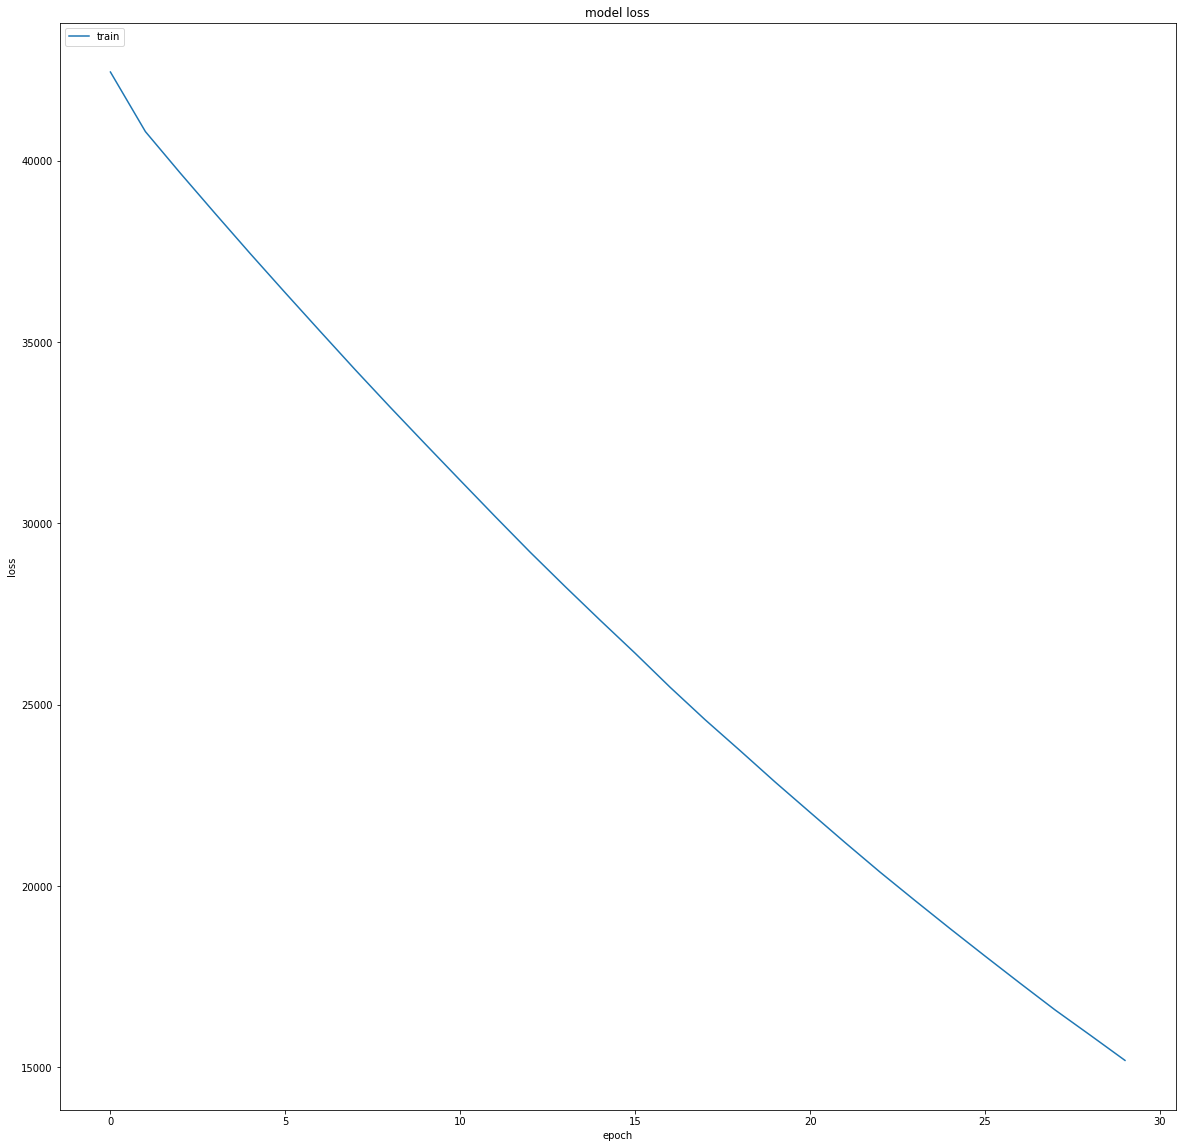

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Notice how the loss stopped declining after few iterations. No further convergence.

# Forecasting
Since the trained model outputs only one-step forecast, then the output can be fed back into the model as a new input to obtain the subsequent observations on a rolling-bases.

In this example, conduct the forecast on a rolling basis:

In [22]:
n_batch = 1
# re-define model
new_model = Sequential()
new_model.add(LSTM(10, activation='relu', batch_input_shape=(n_batch, dim, 1), stateful=True, return_sequences=True))
new_model.add(LSTM(10, activation='relu', input_shape=(dim, 1), stateful=True, return_sequences=False))
new_model.add(Dense(1))
# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)

In [81]:
n_batch = 1
dim = len_feature_lag
new_model = Sequential()
new_model.add(LSTM(8, return_sequences = True, stateful=True, batch_input_shape=(n_batch, dim, 1)))
new_model.add(keras.layers.Dropout(0.2))
new_model.add(LSTM(32, return_sequences = True, stateful=True))
new_model.add(keras.layers.Dropout(0.2))
new_model.add(LSTM(15, return_sequences = False, stateful=True))
new_model.add(keras.layers.Dropout(0.2))
new_model.add(Dense(1))

# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)

In [35]:
# Build the model
new_model = Sequential()
new_model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]),return_sequences=True))
new_model.add(keras.layers.Dropout(0.2))
new_model.add(LSTM(10,return_sequences=True))
new_model.add(keras.layers.Dropout(0.2))
new_model.add(LSTM(15, return_sequences = False))
new_model.add(keras.layers.Dropout(0.2))
new_model.add(Dense( units=1))
new_model.add(keras.layers.Activation('linear'))

# create the list of difference between prediction and test data
# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)

bs = 1
diff=[]
ratio=[]
p = new_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

In [84]:
from datetime import timedelta

forecasts = pd.DataFrame(columns=train_ts_processed.columns, index=val_ts.index)
attached_df = pd.concat([train_ts_processed[-48:], forecasts], axis=0)
print(forecasts.head())
print(attached_df.head())
attached_df.fillna(0.0,inplace=True)
forecasts.fillna(0.0,inplace=True)
for t in forecasts.index:
    for l in new_feature_cols_lag:#[1,2,3,24,48]:
        #print("*****",t,timedelta(minutes=l))
        #print(t - timedelta(minutes=l))
        #print(attached_df.head(2))
        try:
            forecasts.loc[t, 'lag-{}'.format(l)] = attached_df.loc[t - timedelta(minutes=l), 'cpc']
        except Exception as e:
            print(e)
    
    #forecasts["hour"] = forecasts.index.hour
    #forecasts["weekday"] = forecasts.index.weekday
    #forecasts['is_weekend'] = forecasts.weekday.isin([5,6])*1
    #step_X = forecasts.loc[t].values[1:].reshape(1,len_feature_lag,1)
    step_X = forecasts.loc[t].values[1:].reshape(1, -1)
    #print(step_X.shape)
    #print(forecasts.loc[t].values[1:].shape)
    #print(type(forecasts.loc[t].values[1:]))
    #step_X = [forecasts.loc[t].values[1:]]#.reshape(1,5,1)
    step_X = scaler.transform(step_X)
    step_X = step_X.reshape(1, len_feature_lag, 1)
    # Take useful feature and standardize them
    #min_max_scaler = preprocessing.StandardScaler()
    #step_X = min_max_scaler.fit_transform(step_X)
    #step_X = pd.DataFrame(step_X)
    #print(step_X.shape)
    # reduce to 2 importants features
    #pca = PCA(n_components=2)
    #step_X = pca.fit_transform(step_X)
    # standardize these 2 new features
    #min_max_scaler = preprocessing.StandardScaler()
    #step_X = min_max_scaler.fit_transform(step_X)
    #step_X = step_X.reshape(step_X.shape[0], len_feature_lag, 1)
    step_y = new_model.predict(step_X, batch_size=1)[0][0]
    attached_df.loc[t, 'cpc'], forecasts.loc[t, 'cpc'] = step_y, step_y

forecasts.head()

                     cpc lag-1 lag-2 lag-3 lag-4 lag-5 lag-6 lag-7 lag-8  \
timestamp_new                                                              
2019-03-13 05:05:00  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2019-03-13 05:06:00  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2019-03-13 05:07:00  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2019-03-13 05:08:00  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2019-03-13 05:09:00  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                    lag-9  ... lag-50 lag-51 lag-52 lag-53 lag-54 lag-55  \
timestamp_new              ...                                             
2019-03-13 05:05:00   NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
2019-03-13 05:06:00   NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
2019-03-13 05:07:00   NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
2019-03-13 05:08:00   NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
2019-03-13 

,cpc,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7,lag-8,lag-9,...,lag-50,lag-51,lag-52,lag-53,lag-54,lag-55,lag-56,lag-57,lag-58,lag-59
timestamp_new,,,,,,,,,,,,,,,,,,,,,
2019-03-13 05:05:00,-0.004777,212.944444,213.194444,213.472222,217.625000,217.750000,211.000000,211.694444,211.972222,212.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-13 05:06:00,-0.004183,-0.004777,212.944444,213.194444,213.472222,217.625000,217.750000,211.000000,211.694444,211.972222,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-13 05:07:00,-0.000742,-0.004183,-0.004777,212.944444,213.194444,213.472222,217.625000,217.750000,211.000000,211.694444,...,210.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-13 05:08:00,0.003030,-0.000742,-0.004183,-0.004777,212.944444,213.194444,213.472222,217.625000,217.750000,211.000000,...,209.666667,210.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-13 05:09:00,0.006930,0.003030,-0.000742,-0.004183,-0.004777,212.944444,213.194444,213.472222,217.625000,217.750000,...,210.000000,209.666667,210.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Validation
Compare forecasts against the hold-out validation set

Text(0.5, 1.0, 'MSE: 44160.69853770967')

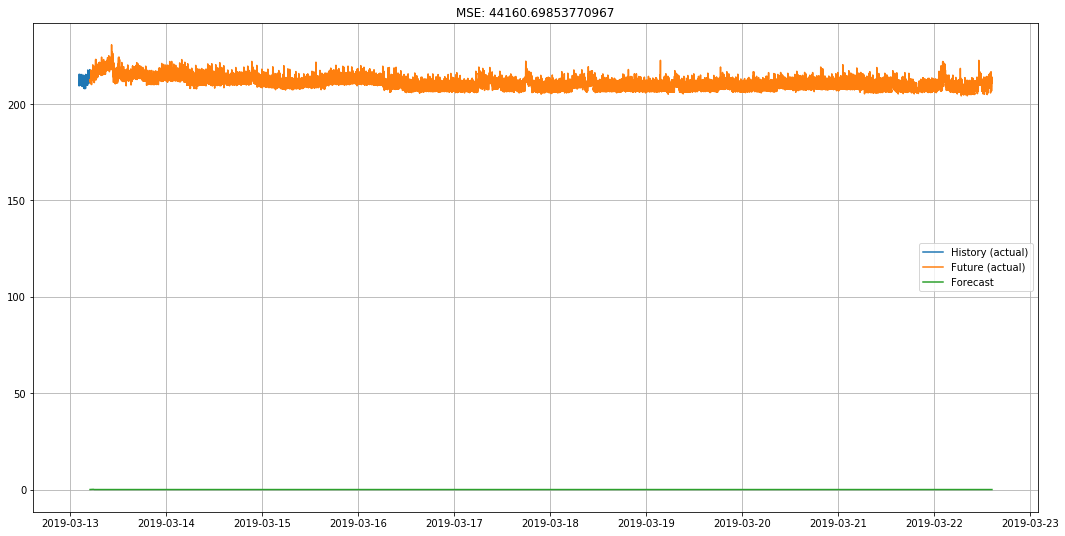

In [85]:
import matplotlib.pyplot as plt

mse = ((val_ts.values - forecasts['cpc'].values)**2).mean()

plt.figure(figsize=(18,9))
plt.plot(train_ts[-24*7:], label='History (actual)')
plt.plot(val_ts, label='Future (actual)')
plt.plot(forecasts['cpc'], label='Forecast')
plt.legend()
plt.grid()
plt.title('MSE: '+ str(mse))

Text(0.5, 1.0, 'MSE: 0.0013646572332092584')

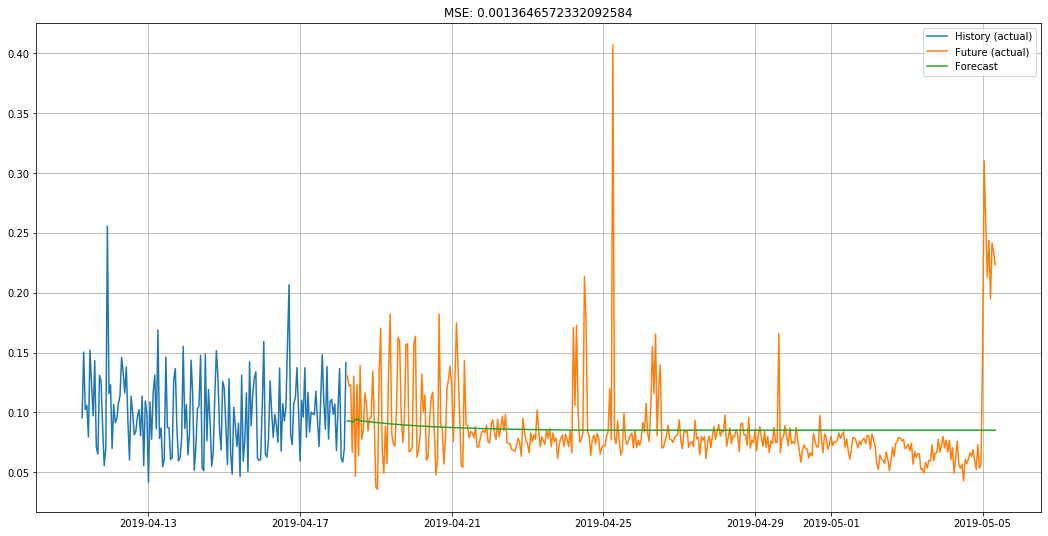

In [97]:
import matplotlib.pyplot as plt

mse = ((val_ts.values - forecasts['cpc'].values)**2).mean()

plt.figure(figsize=(18,9))
plt.plot(train_ts[-24*7:], label='History (actual)')
plt.plot(val_ts, label='Future (actual)')
plt.plot(forecasts['cpc'], label='Forecast')
plt.legend()
plt.grid()
plt.title('MSE: '+ str(mse))

In general, the accuracy of the one-step ahead forecast problem declines for longer forecast periods, although it is clear that the neural network had learned the cyclic pattern (24 hr seasonality). Several things may have gone wrong, including:
* The problem may have been ill defined: batch size and input shape
* Removing the trend might help (differencing or seasonal-differencing)
* Neural network design (e.g. layers, neurons, activation, statefulness, etc.)
* Longer training period required (epochs)
* Data scale (normalziation or standardization)
* For long term forcasting with seasonal data, seq2seq might be better
* Hyper-parameter optimization

# LSTM AutoEncoders
https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/
http://philipperemy.github.io/anomaly-detection/


In [3]:
import keras
#from keras.models import Sequential
#from keras.layers.recurrent import LSTM
import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

Using TensorFlow backend.


In [4]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train_ts[['cpc']])

train_ts['cpc'] = scaler.transform(train_ts[['cpc']])
val_ts['cpc'] = scaler.transform(val_ts[['cpc']])
test_ts['cpc'] = scaler.transform(test_ts[['cpc']])

In [11]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [12]:
TIME_STEPS = 24

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(
  train_ts[['cpc']],
  train_ts.cpc,
  TIME_STEPS
)
#y_train = np.reshape(y_train, y_train.shape + (1,))
#y_train = np.reshape(y_train, y_train.shape + (1,))

X_val, y_val = create_dataset(
  val_ts[['cpc']],
  val_ts.cpc,
  TIME_STEPS
)

X_test, y_test = create_dataset(
  test_ts[['cpc']],
  test_ts.cpc,
  TIME_STEPS
)

print(X_train.shape,X_val.shape,y_train.shape)

(63105, 24, 1) (13504, 24, 1) (63105,)


In [35]:
bs = 24
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    #input_shape=(X_train.shape[1], X_train.shape[2])
    batch_input_shape=(bs, X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)

model.summary()

model.compile(loss='mae', optimizer='adam')

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (24, 64)                  16896     
_________________________________________________________________
dropout_20 (Dropout)         (24, 64)                  0         
_________________________________________________________________
repeat_vector_12 (RepeatVect (24, 24, 64)              0         
_________________________________________________________________
lstm_30 (LSTM)               (24, 24, 64)              33024     
_________________________________________________________________
dropout_21 (Dropout)         (24, 24, 64)              0         
_________________________________________________________________
time_distributed_11 (TimeDis (24, 24, 1)               65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________

In [13]:
epochs = 20
bs = 64
lr = 0.0001

model = Sequential()
# Encoder
model.add(LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=False))
model.add(keras.layers.RepeatVector(X_train.shape[1]))
# Decoder
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(keras.layers.TimeDistributed(Dense(X_train.shape[2])))

model.summary()
cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
#model.compile(loss='mae', optimizer='adam')
adam = optimizers.Adam(lr)
model.compile(loss='mse', optimizer=adam)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 24, 32)            4352      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 24, 16)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 16)            2112      
_________________________________________________________________
lstm_8 (LSTM)                (None, 24, 32)            6272      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 1)             33        
Total params: 15,905
Trainable params: 15,905
Non-trainable params: 0
__________________________________________________

In [14]:
lstm_autoencoder_history = model.fit(X_train, X_train, 
                                                epochs=40, 
                                                batch_size=bs, 
                                                validation_data=(X_val, X_val),
                                                verbose=2, shuffle=False).history

Train on 63105 samples, validate on 13504 samples
Epoch 1/40
 - 64s - loss: 4.8280 - val_loss: 0.9796
Epoch 2/40
 - 62s - loss: 36.9153 - val_loss: 0.9474
Epoch 3/40
 - 61s - loss: 0.9077 - val_loss: 0.9165
Epoch 4/40
 - 61s - loss: 0.8319 - val_loss: 0.8885
Epoch 5/40
 - 60s - loss: 0.7788 - val_loss: 0.8656
Epoch 6/40
 - 60s - loss: 0.7455 - val_loss: 0.8516
Epoch 7/40
 - 59s - loss: 0.7261 - val_loss: 0.8390
Epoch 8/40
 - 59s - loss: 0.7133 - val_loss: 0.8243
Epoch 9/40
 - 59s - loss: 0.6997 - val_loss: 0.8089
Epoch 10/40
 - 60s - loss: 0.6819 - val_loss: 0.7956
Epoch 11/40
 - 59s - loss: 0.6500 - val_loss: 0.7478
Epoch 12/40
 - 59s - loss: 0.6196 - val_loss: 0.7405
Epoch 13/40
 - 58s - loss: 0.5932 - val_loss: 0.6923
Epoch 14/40
 - 59s - loss: 0.5789 - val_loss: 0.6809
Epoch 15/40
 - 58s - loss: 0.5625 - val_loss: 0.6724
Epoch 16/40
 - 58s - loss: 0.5520 - val_loss: 0.6514
Epoch 17/40
 - 59s - loss: 0.5387 - val_loss: 0.6321
Epoch 18/40
 - 59s - loss: 0.5208 - val_loss: 0.6076
Epoc

In [38]:
history = model.fit( X_train, X_train, epochs=10, batch_size=bs, validation_split=0.1, shuffle=False)

Train on 29678 samples, validate on 3298 samples
Epoch 1/10
29678/29678 [==============================] - 31s 1ms/step - loss: 0.5778 - val_loss: 0.5169
Epoch 2/10
29678/29678 [==============================] - 29s 981us/step - loss: 0.5100 - val_loss: 0.5037
Epoch 3/10
29678/29678 [==============================] - 29s 978us/step - loss: 0.5064 - val_loss: 0.5082
Epoch 4/10
29678/29678 [==============================] - 29s 975us/step - loss: 0.4973 - val_loss: 0.4907
Epoch 5/10
29678/29678 [==============================] - 29s 971us/step - loss: 0.4824 - val_loss: 0.4819
Epoch 6/10
29678/29678 [==============================] - 29s 964us/step - loss: 0.4884 - val_loss: 0.4801
Epoch 7/10
29678/29678 [==============================] - 29s 977us/step - loss: 0.5144 - val_loss: 0.4789
Epoch 8/10
29678/29678 [==============================] - 29s 976us/step - loss: 0.4744 - val_loss: 0.4654
Epoch 9/10
29678/29678 [==============================] - 30s 1ms/step - loss: 0.4615 - val_loss:

In [40]:
#history = model.fit( X_train, X_train, epochs=10, batch_size=bs, validation_split=0.1, shuffle=False)

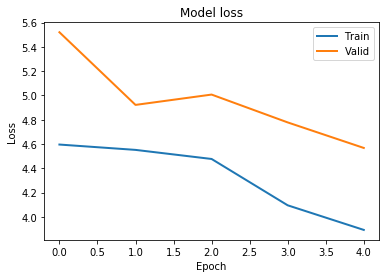

In [45]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

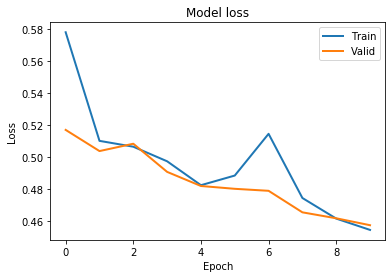

In [54]:
lstm_autoencoder_history = history.history
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

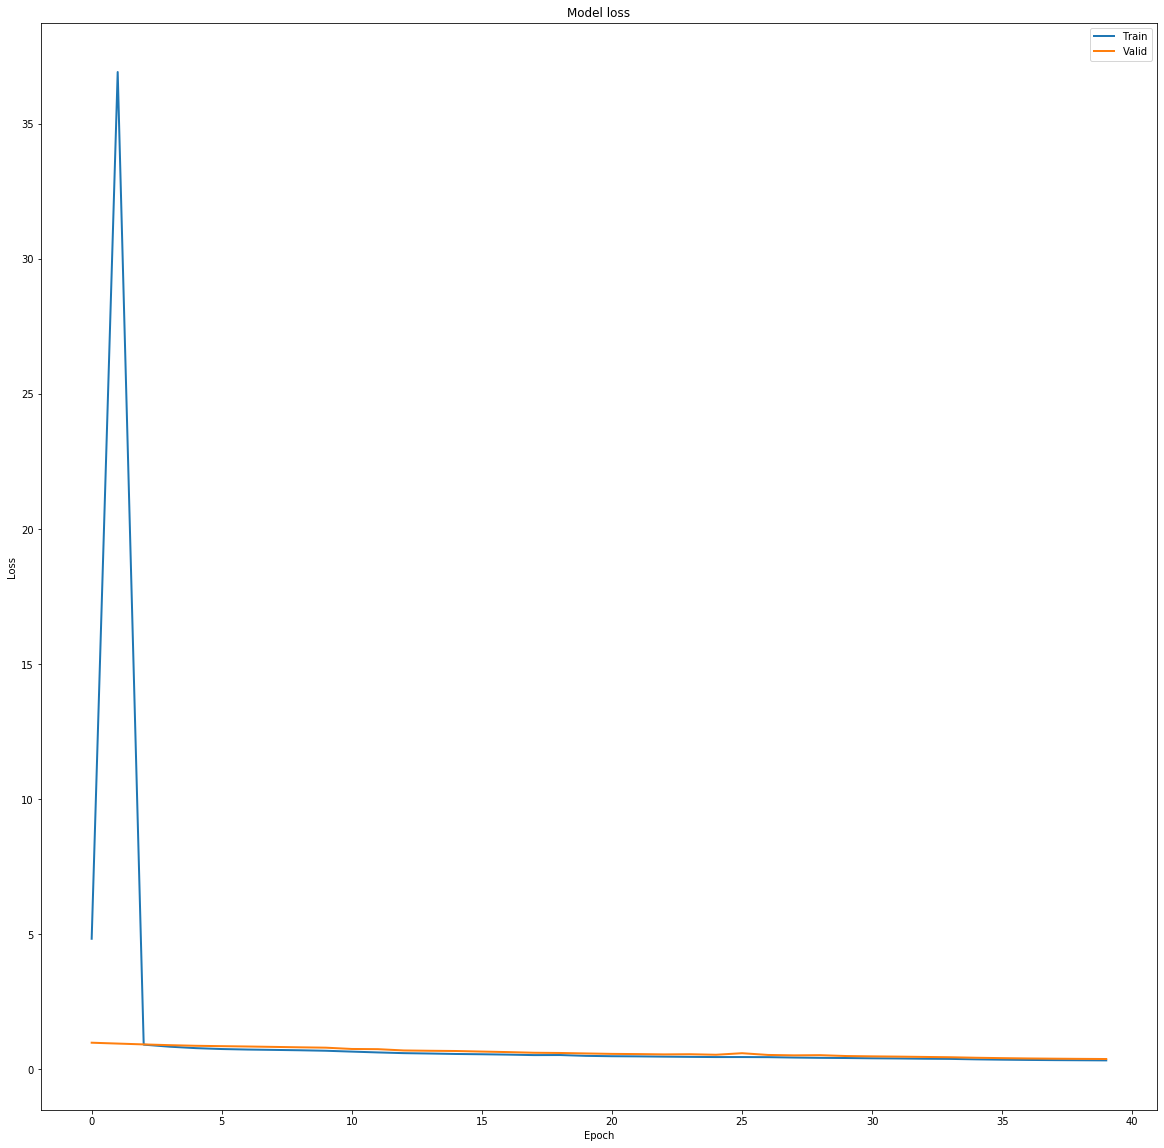

In [16]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [15]:
valid_x_predictions = model.predict(X_test)
mse = np.mean(np.power(flatten(X_test) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})
print(error_df.True_class)
print(error_df.Reconstruction_error)
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

0        209.694444
1        210.666667
2        209.972222
3        214.541667
4        212.291667
            ...    
13498    212.083333
13499    208.666667
13500    208.333333
13501    209.000000
13502    210.166667
Name: True_class, Length: 13503, dtype: float64
0        12.823588
1         1.770159
2         0.052683
3         1.111125
4         5.098383
           ...    
13498     0.007810
13499     0.406195
13500    10.193971
13501    14.708174
13502     7.139079
Name: Reconstruction_error, Length: 13503, dtype: float64


ValueError: continuous format is not supported

In [52]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [56]:
print(train_mae_loss.mean(),train_mae_loss.max(),train_mae_loss.min())

1.4824808892164185 16.201513290405277 0.20432445396761048


(array([6.2937e+04, 1.4700e+02, 1.3000e+01, 3.0000e+00, 5.0000e+00]),
 array([ 0.20432445,  3.40376222,  6.60319999,  9.80263776, 13.00207552,
        16.20151329]),
 <a list of 5 Patch objects>)

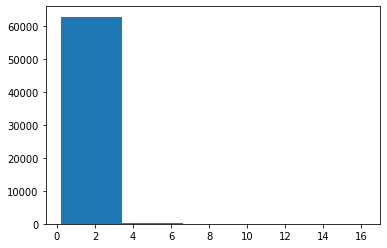

In [58]:
plt.hist(train_mae_loss, bins = 5)

(0.0, 5810.0)

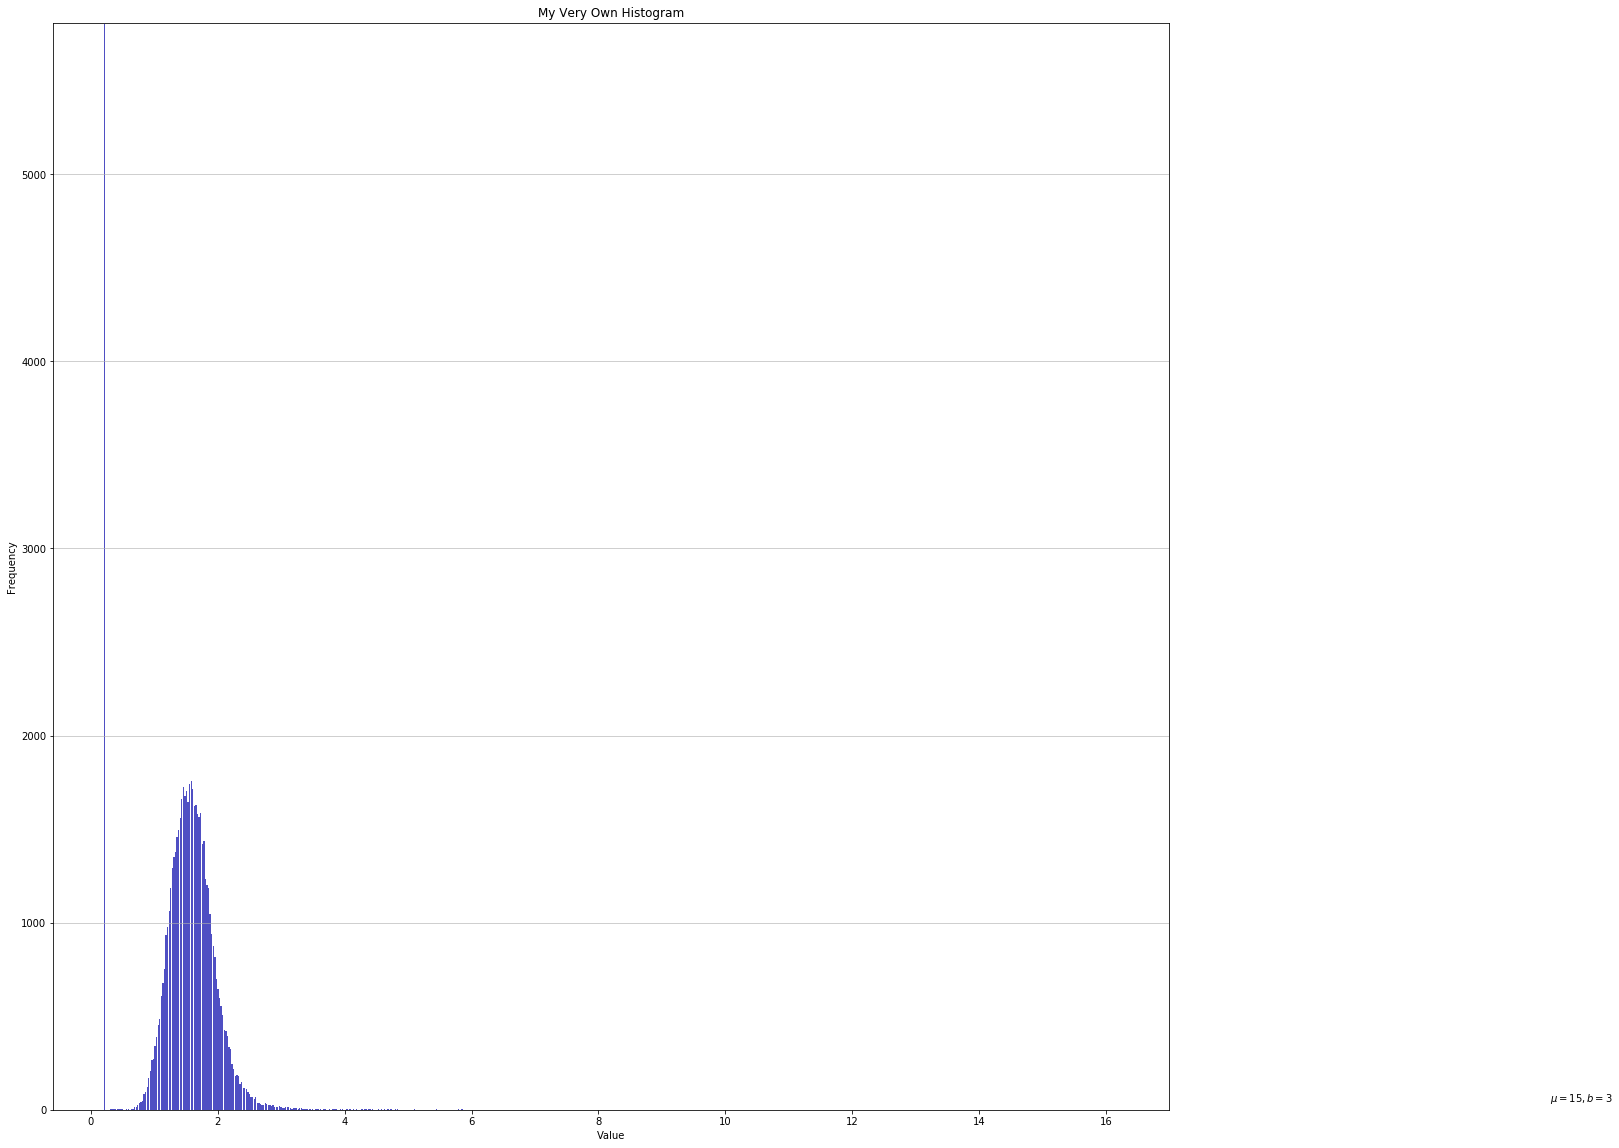

In [89]:
n, bins, patches = plt.hist(x=train_mae_loss, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

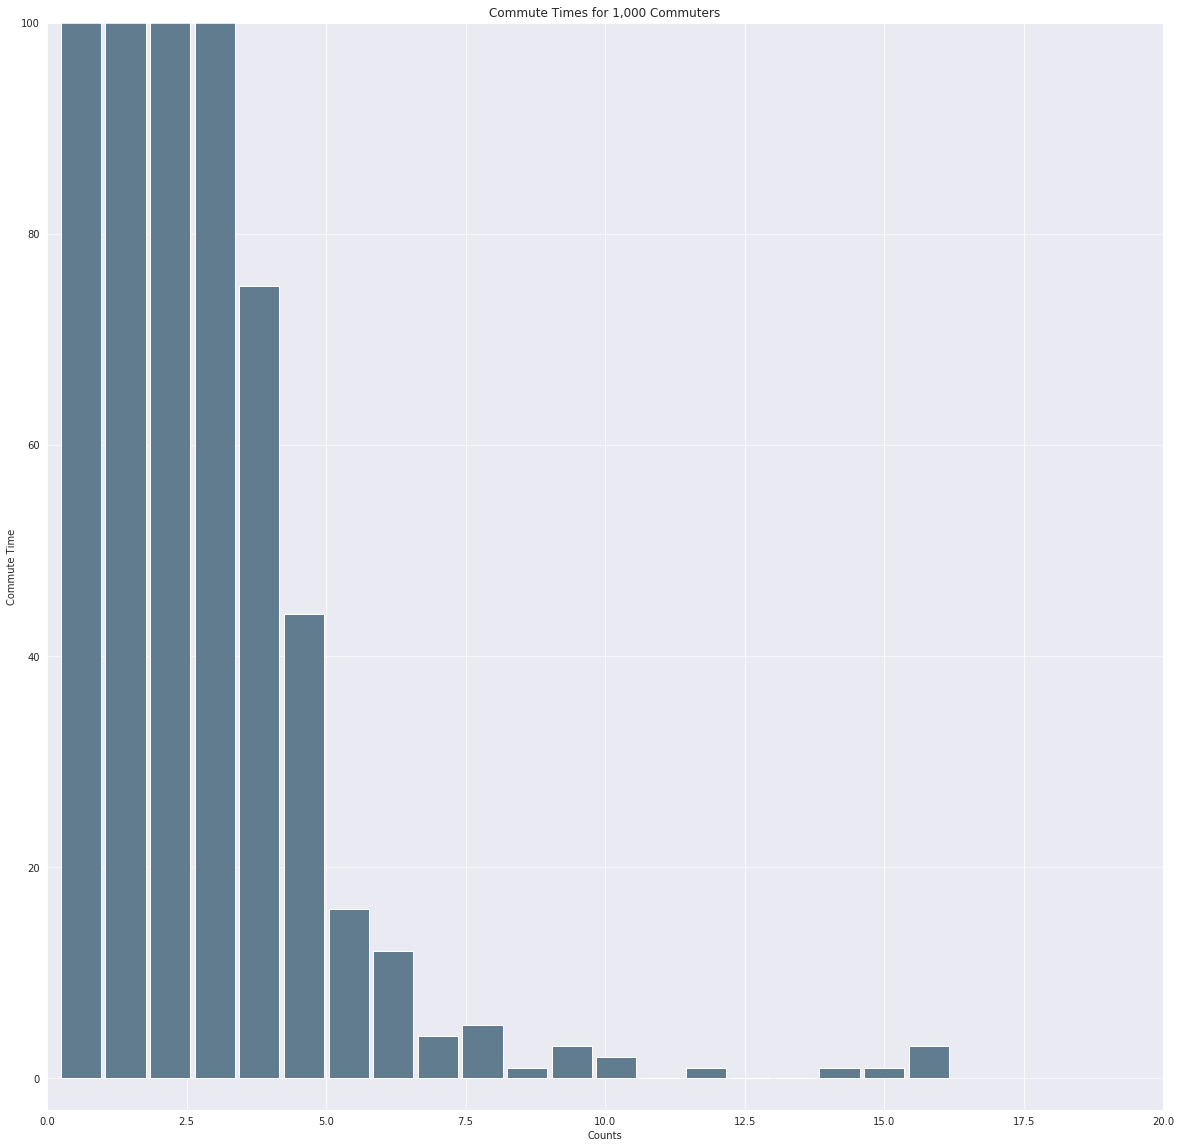

In [109]:
series_mse = pd.Series(train_mae_loss.flatten())
series_mse.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlim([0, 20])
plt.ylim([-3, 100])
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

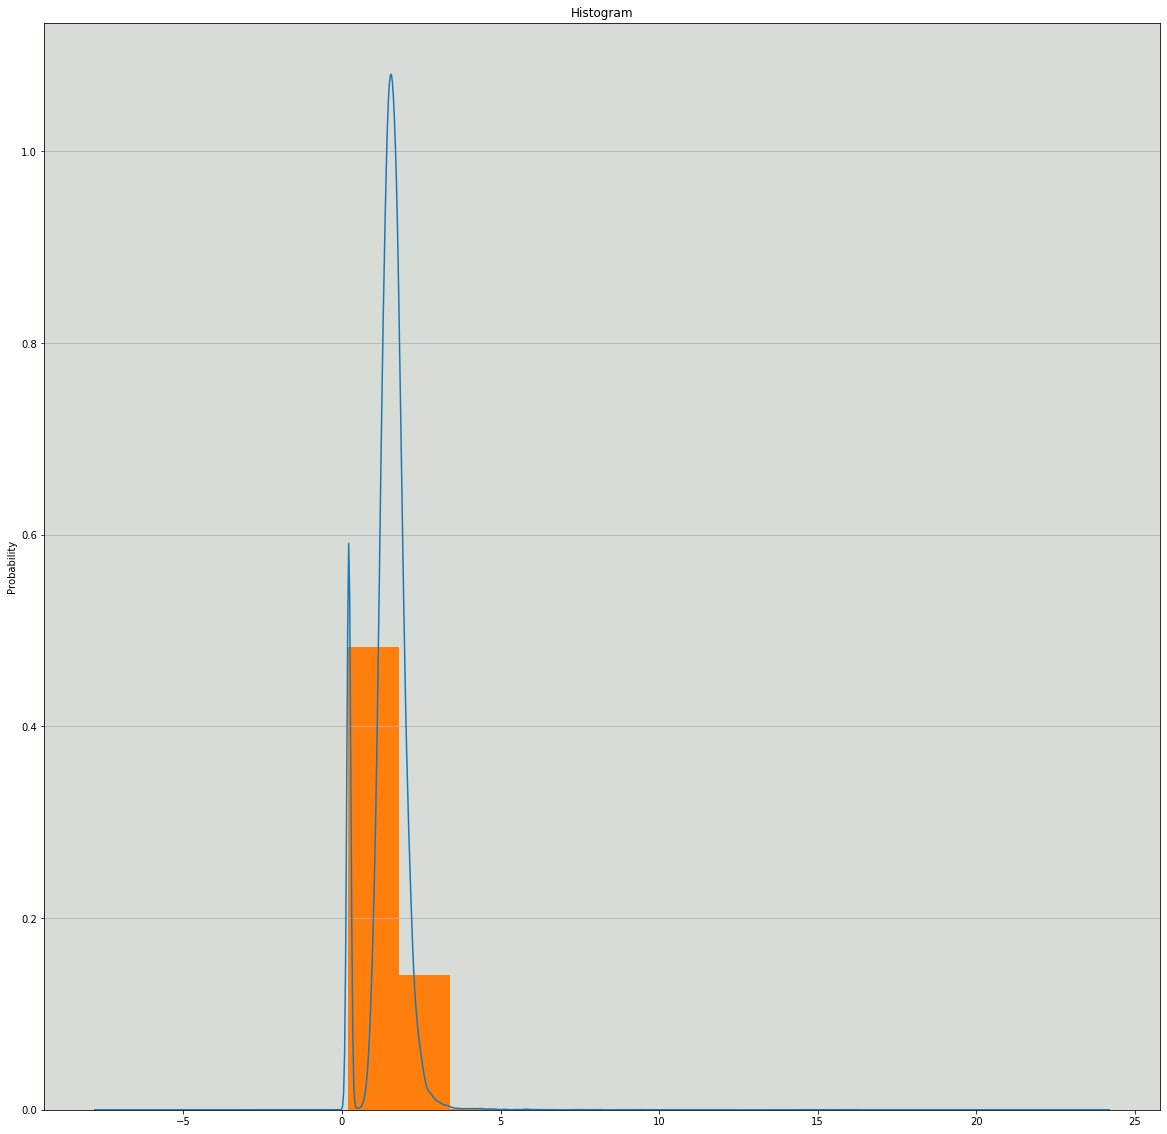

In [97]:
fig, ax = plt.subplots()
series_mse.plot.kde(ax=ax, legend=False, title='Histogram')
series_mse.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

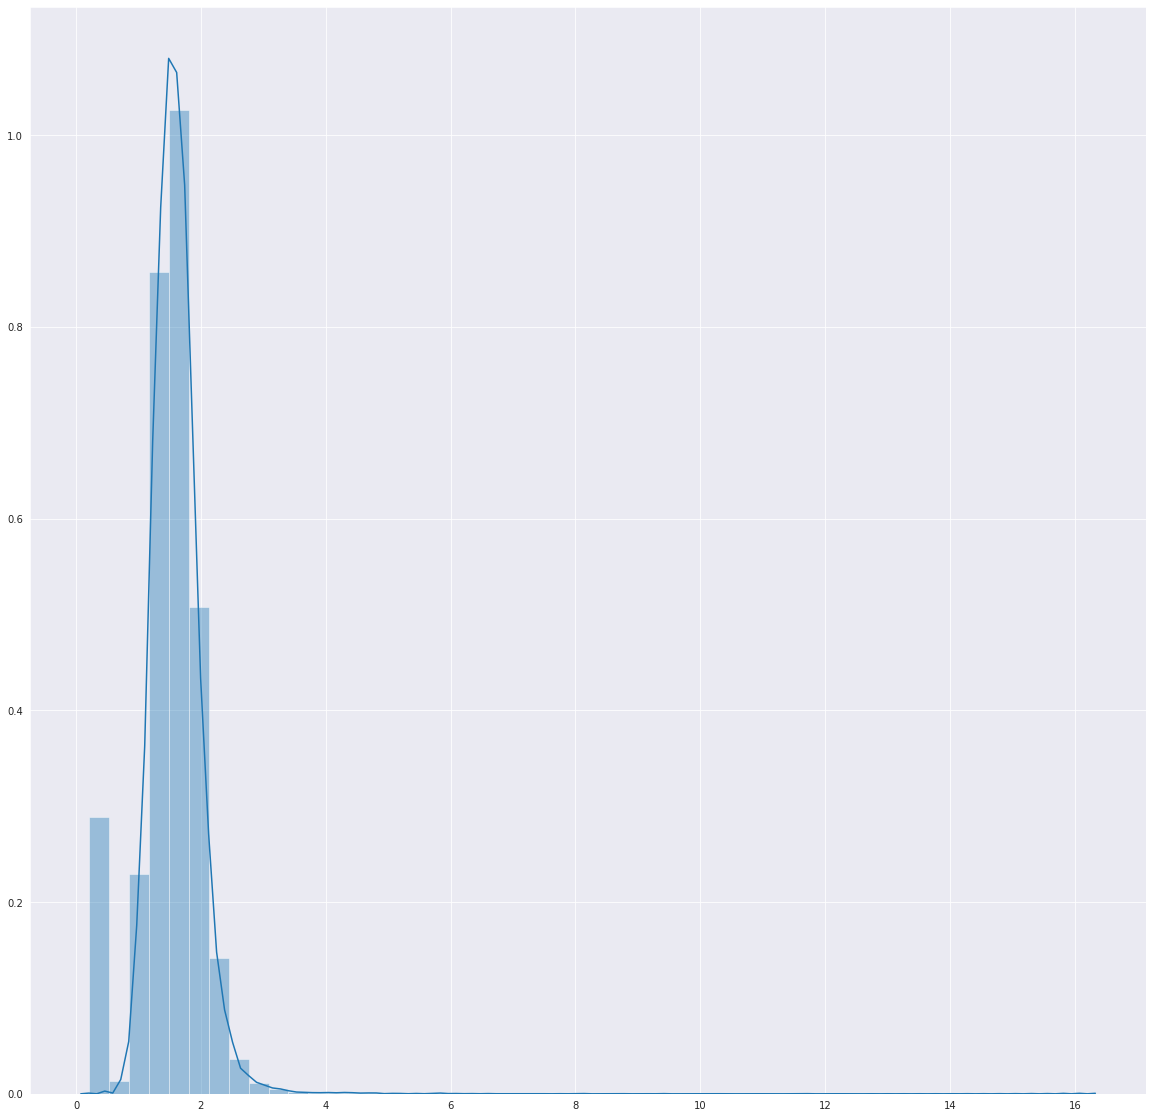

In [98]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(series_mse)

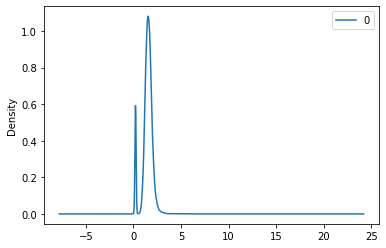

In [60]:
pd.DataFrame(train_mae_loss).plot(kind='density')

In [20]:
THRESHOLD = 0.65

In [46]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
print(test_mae_loss.mean())

1.476289911730253


In [17]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
print(test_mae_loss.mean())

0.42205999457705484


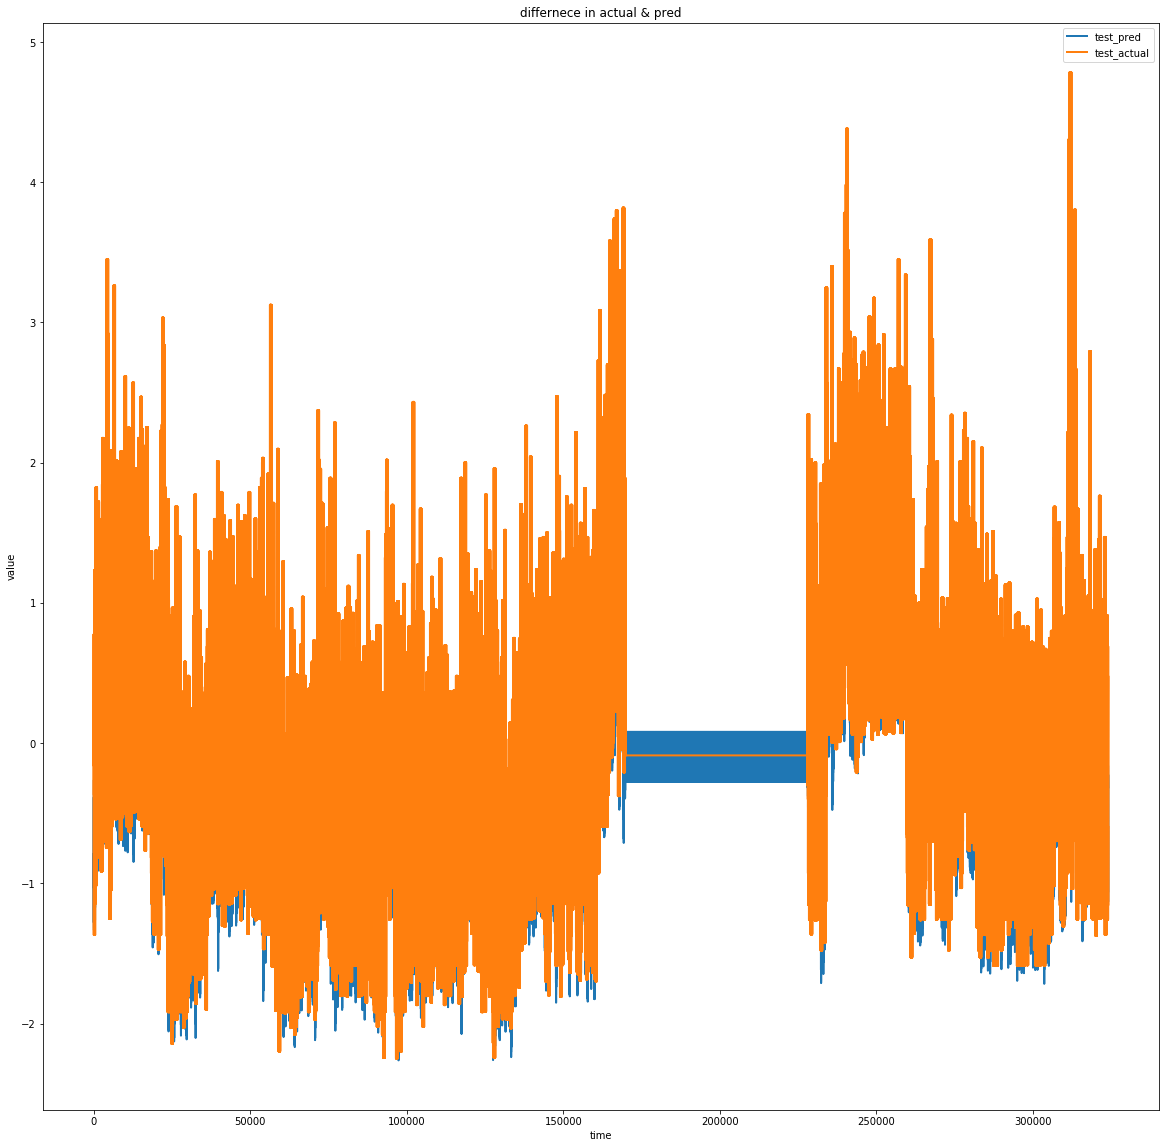

In [18]:
plt.plot(X_test_pred.flatten(), linewidth=2, label='test_pred')
plt.plot(X_test.flatten(), linewidth=2, label='test_actual')
plt.legend(loc='upper right')
plt.title('differnece in actual & pred')
plt.ylabel('value')
plt.xlabel('time')
plt.show()

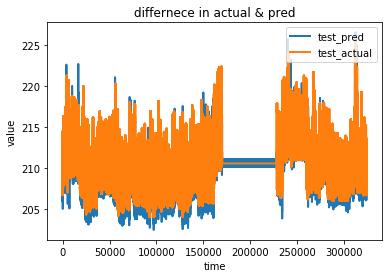

In [47]:
plt.plot(X_test_pred.flatten(), linewidth=2, label='test_pred')
plt.plot(X_test.flatten(), linewidth=2, label='test_actual')
plt.legend(loc='upper right')
plt.title('differnece in actual & pred')
plt.ylabel('value')
plt.xlabel('time')
plt.show()

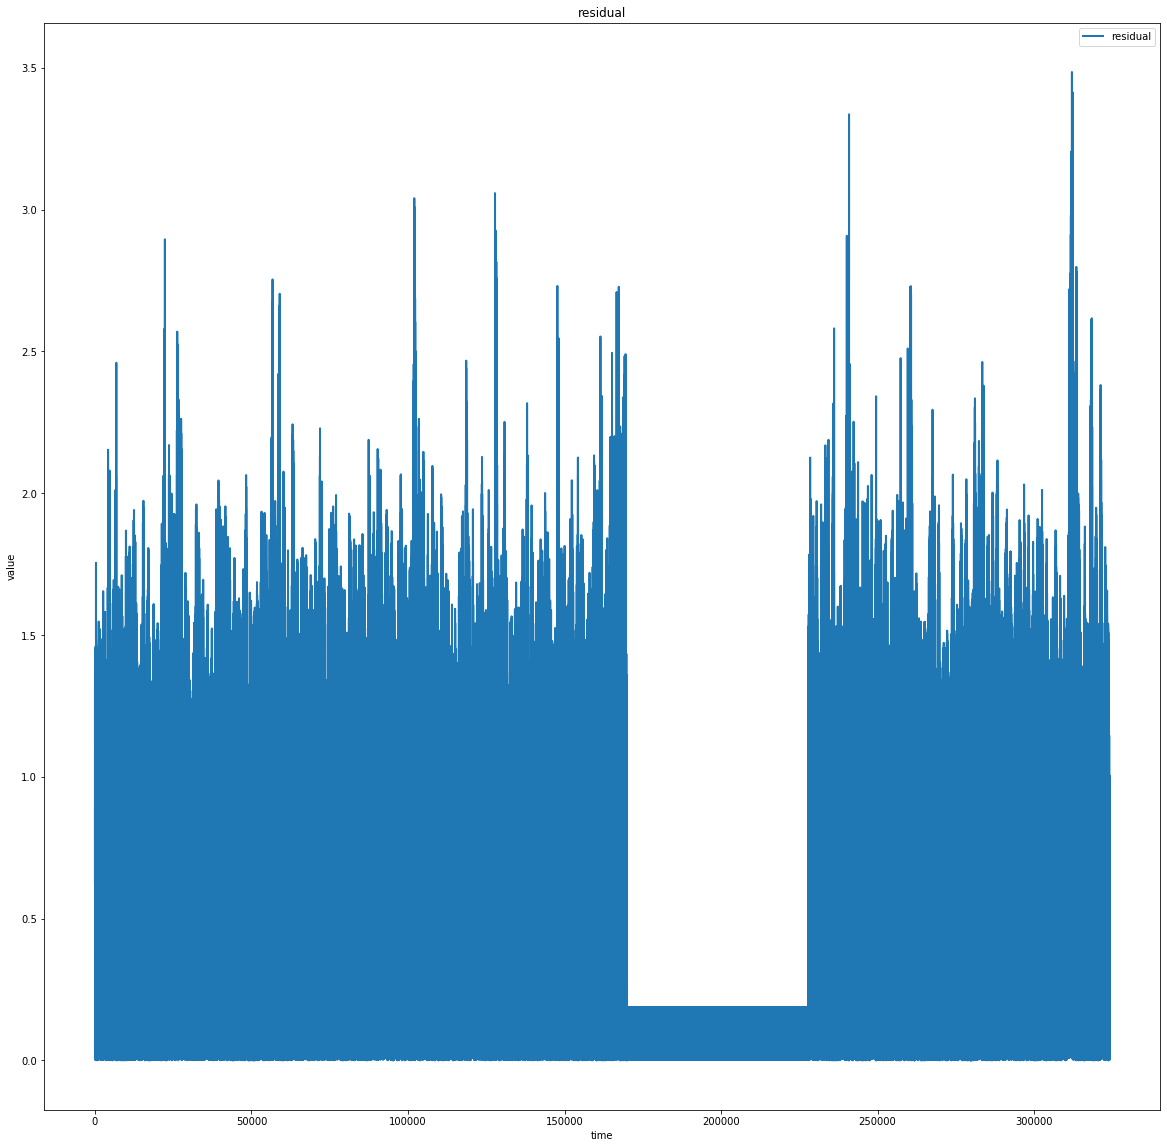

In [33]:
residual = np.abs(X_test_pred - X_test)
plt.plot(residual.flatten(), linewidth=2, label='residual')
plt.legend(loc='upper right')
plt.title('residual')
plt.ylabel('value')
plt.xlabel('time')
plt.show()

In [27]:
#from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import OneClassSVM

In [57]:
residual.shape
residual.reshape(residual.shape[0],residual.shape[1]).shape

(13503, 24)

In [63]:
#y_test.shape
ts2_copy

0                                                  -0.369126
1                                                 -0.0481159
2                                                  -0.277409
3                                                    1.23134
4                                                    0.48843
                                 ...                        
13499                                               -0.70848
13500                                               -0.81854
13501                                              -0.598419
13502                                              -0.213207
anomaly    0        1
1        1
2        1
3        1
4 ...
Length: 13504, dtype: object

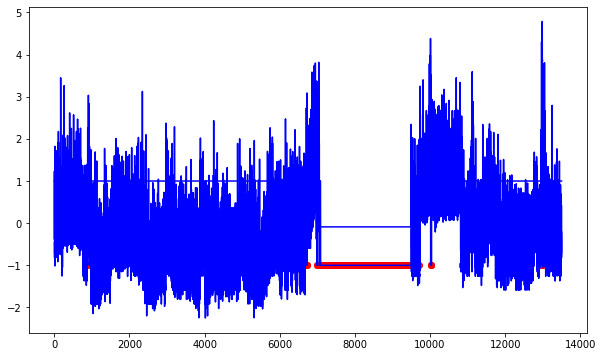

In [68]:
ts2 = pd.DataFrame(y_test, columns = ['cpc']) #pd.Series(y_test)
ts2_copy = ts2.copy()
# train oneclassSVM 
outliers_fraction = 0.01
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(residual.reshape(residual.shape[0],residual.shape[1]))
ts2_pred = model.predict(residual.reshape(residual.shape[0],residual.shape[1]))
ts2_copy['anomaly'] = pd.Series(ts2_pred)

fig, ax = plt.subplots(figsize=(10,6))
a = ts2_copy.loc[ts2_copy['anomaly'] == -1] #anomaly

ax.plot(ts2_copy.index, ts2_copy, color='blue')
ax.scatter(a.index,a.anomaly, color='red')
plt.show();

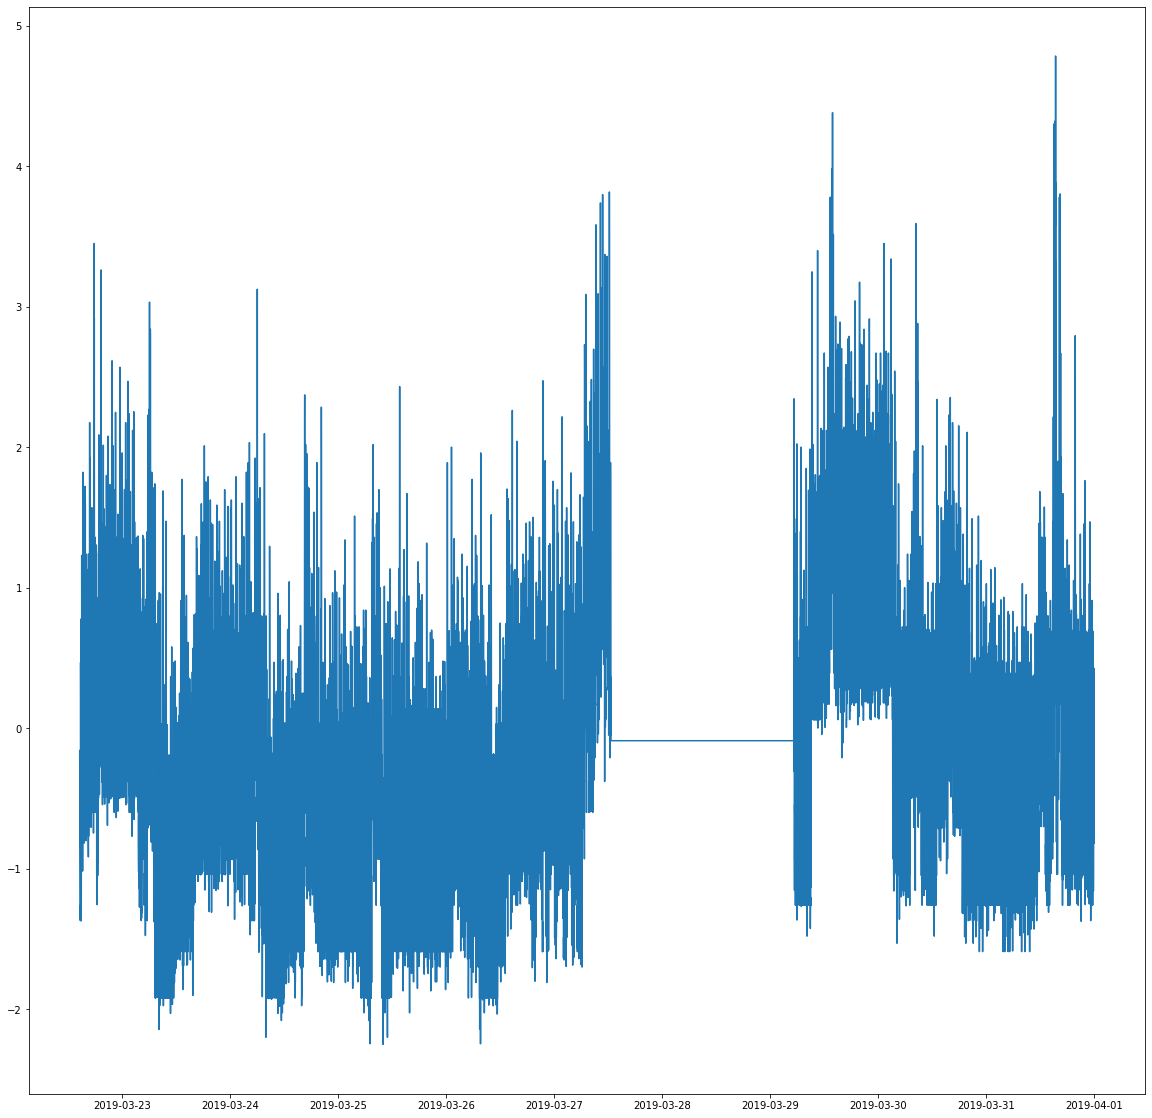

In [70]:
plt.plot(test_ts)

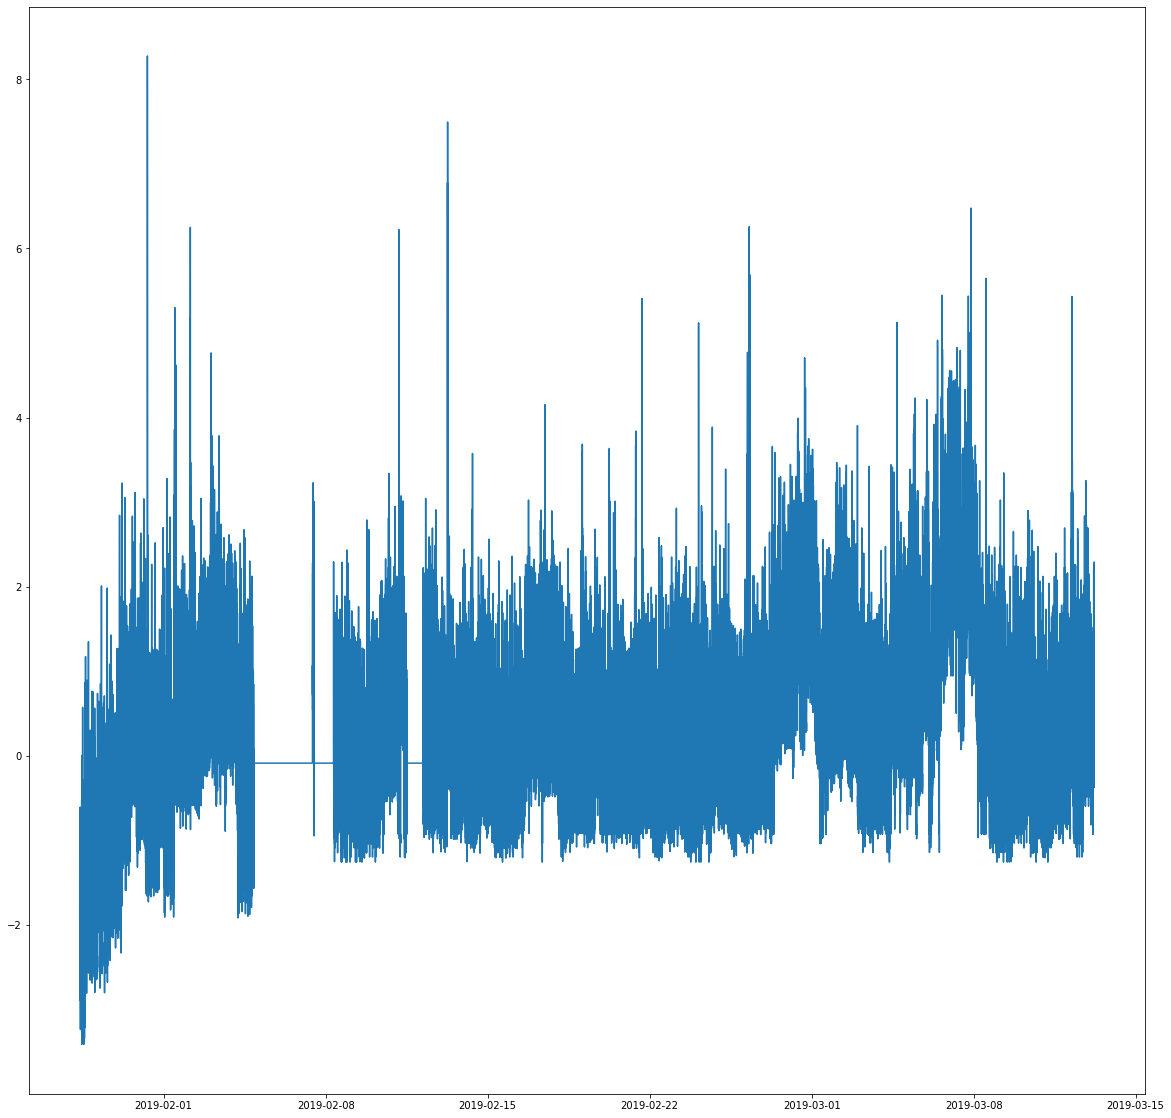

In [71]:
plt.plot(train_ts)

4.292707700453629


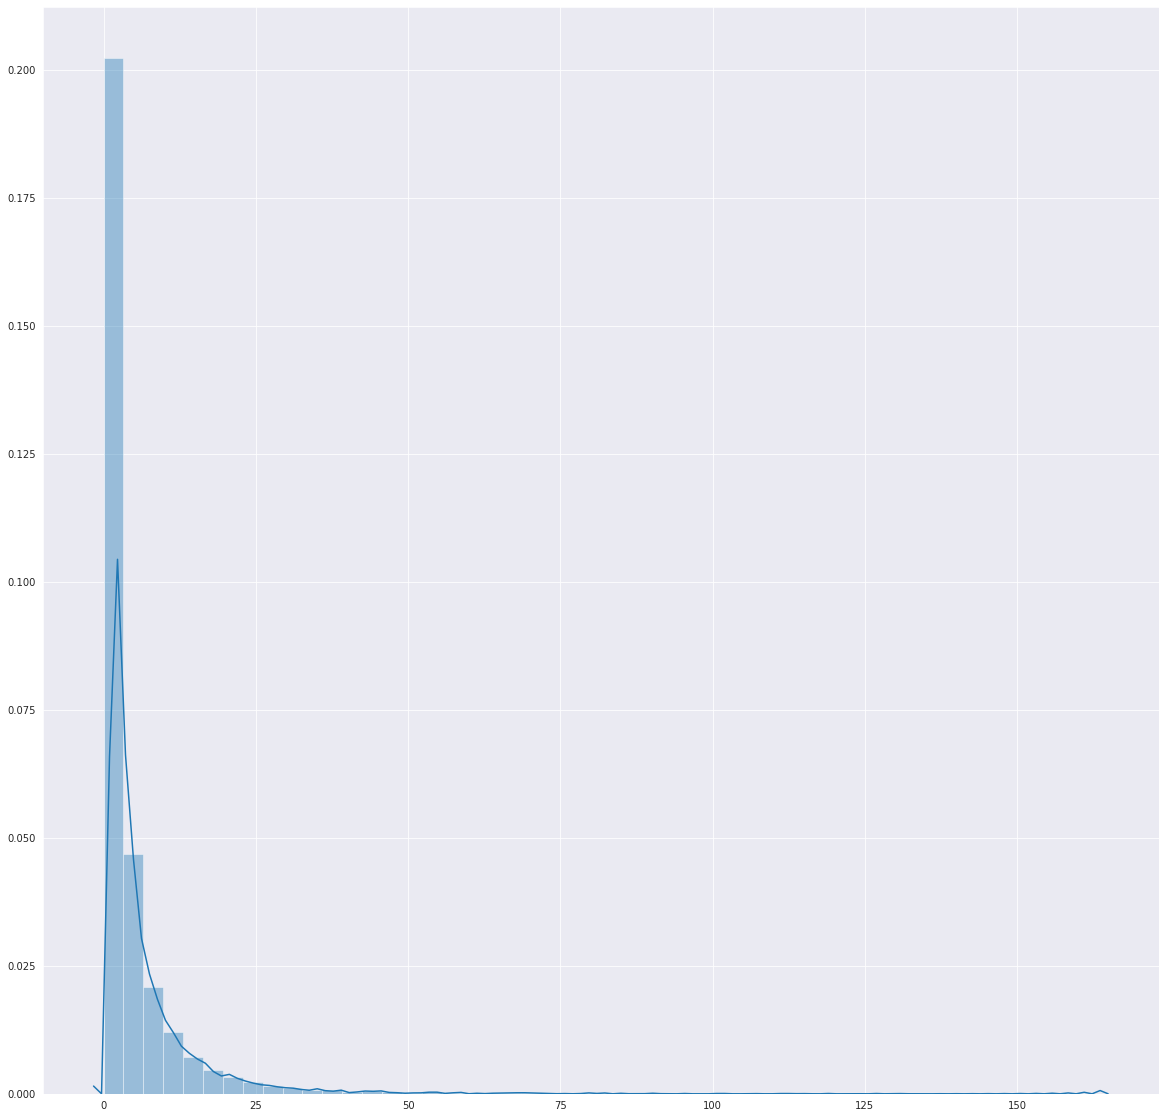

In [110]:
mse = np.mean(np.power(flatten(X_test) - flatten(X_test_pred), 2), axis=1)
print(mse.mean())
sns.set_style('darkgrid')
sns.distplot(mse)

In [19]:
mse = np.mean(np.power(flatten(X_test) - flatten(X_test_pred), 2), axis=1)
print(mse.mean())
sns.set_style('darkgrid')
sns.distplot(mse)

0.3162972261047914


NameError: name 'sns' is not defined

In [67]:
test_score_df = pd.DataFrame(index=test_ts[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold_up'] = 3.5
test_score_df['threshold_down'] = THRESHOLD
#test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['anomaly'] = test_score_df.loss < test_score_df.threshold_down or test_score_df.loss > test_score_df.threshold_up
test_score_df['anomaly'] = test_score_df[(test_score_df['loss'] > 3.5) | (test_score_df['loss'] < THRESHOLD)]
test_score_df['cpc'] = test_ts[TIME_STEPS:].cpc
#test_score_df['pred'] = X_test_pred[TIME_STEPS:]

ValueError: Wrong number of items passed 3, placement implies 1

In [21]:
from sklearn.metrics import average_precision_score, recall_score, precision_score, f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

LABELS = ["Normal", "Fraud"]

def predict(data):
    target_data = model.predict(x=data)
    dist = np.linalg.norm(data - target_data, axis=-1)
    return dist

def anomaly(data, threshold=None):
    if threshold is not None:
        threshold = threshold

    dist = predict(data)
    return zip(dist >= self.threshold, dist)

def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()


def plot_training_history(history):
    if history is None:
        return
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


def visualize_anomaly(y_true, reconstruction_error, threshold):
    error_df = pd.DataFrame({'reconstruction_error': reconstruction_error,
                             'true_class': y_true})
    print(error_df.describe())

    groups = error_df.groupby('true_class')
    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label="Fraud" if name == 1 else "Normal")

    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()


def visualize_reconstruction_error(reconstruction_error, threshold):
    plt.plot(reconstruction_error, marker='o', ms=3.5, linestyle='',
             label='Point')

    plt.hlines(threshold, xmin=0, xmax=len(reconstruction_error)-1, colors="r", zorder=100, label='Threshold')
    plt.legend()
    plt.title("Reconstruction error")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

def report_evaluation_metrics(y_true, y_pred):
    average_precision = average_precision_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels=[0, 1], pos_label=1)
    recall = recall_score(y_true, y_pred, labels=[0, 1], pos_label=1)
    f1 = f1_score(y_true, y_pred, labels=[0, 1], pos_label=1)

    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print('Precision: {0:0.2f}'.format(precision))
    print('Recall: {0:0.2f}'.format(recall))
    print('F1: {0:0.2f}'.format(f1))



In [ ]:
reconstruction_error = []
adjusted_threshold = 4
anomaly_information = ae.anomaly(Xtest, adjusted_threshold)
for idx, (is_anomaly, dist) in enumerate(anomaly_information):
    predicted_label = 1 if is_anomaly else 0
    Ypred.append(predicted_label)
    reconstruction_error.append(dist)

report_evaluation_metrics(y_true, y_pred)
plot_training_history(history)
visualize_anomaly(Ytest, reconstruction_error, adjusted_threshold)
plot_confusion_matrix(Ytest, Ypred)

In [78]:
anomaly_df = test_score_df[(test_score_df['loss'] > 4.0) | (test_score_df['loss'] < 0.25)]
non_anomaly_df = test_score_df[~test_score_df.index.isin(anomaly_df.index)]
print(len(anomaly_df),len(non_anomaly_df))

2420 11083


In [80]:
non_anomaly_df.columns

Index(['loss', 'threshold_up', 'threshold_down'], dtype='object')

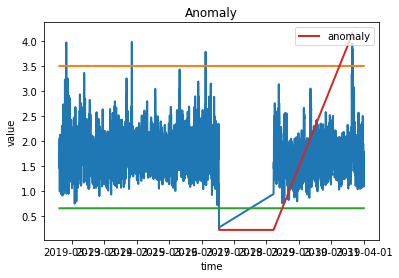

In [84]:
plt.plot(non_anomaly_df, linewidth=2)
plt.plot(anomaly_df.loss, linewidth=2, label='anomaly')
plt.legend(loc='upper right')
plt.title('Anomaly')
plt.ylabel('value')
plt.xlabel('time')
plt.show()

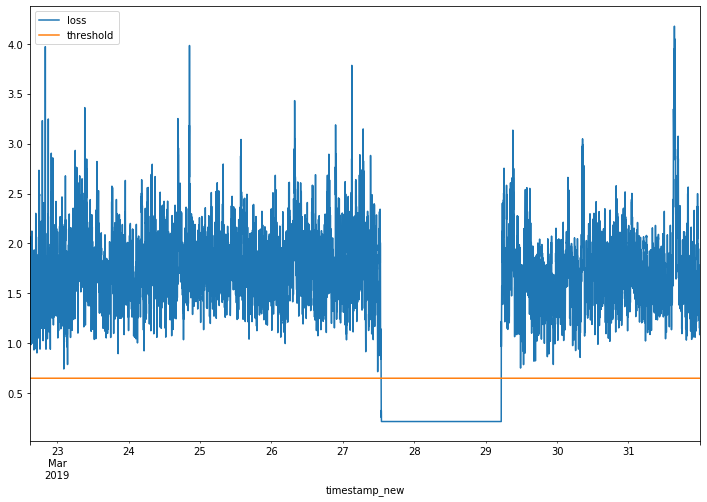

In [51]:
test_score_df[['loss','threshold']].plot(figsize=(12,8))

In [61]:
anomalies = test_score_df[test_score_df.anomaly == True][['loss','threshold']]

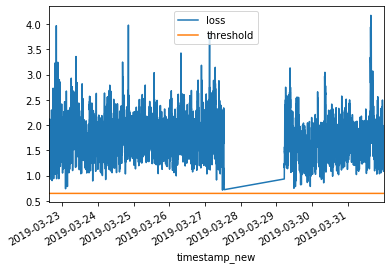

In [62]:
anomalies.plot()

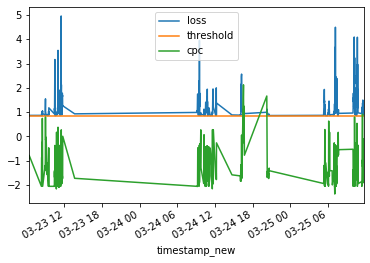

In [69]:
anomalies.plot()

In [ ]:
from keras.models import Sequential, load_model
from keras.callbacks import History, EarlyStopping, Callback
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout,Flatten
import numpy as np
import os
from servanom._globals import Config
import tensorflow as tf

#config
config = Config("config.yaml")
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # suppress tensorflow CPU speedup warnings


def get_model(anom, X_train, y_train, logger, train=False):
    '''Train LSTM model according to specifications in config.yaml or load pre-trained model.

    Args:
        anom (dict): contains all anomaly information for a given input stream
        X_train (np array): numpy array of training inputs with dimensions [timesteps, l_s, input dimensions)
        y_train (np array): numpy array of training outputs corresponding to true values following each sequence
        logger (obj): logging object
        train (bool): If False, will attempt to load existing model from repo

    Returns:
        model (obj): Trained Keras LSTM model 
    '''

    if not train and os.path.exists(os.path.join("data", "models", anom["chan_id"] + ".h5")):
        logger.info("Loading pre-trained model")
        return load_model(os.path.join("data", config.use_id, "models", anom["chan_id"] + ".h5"))

    elif (not train and not os.path.exists(os.path.join("data", config.use_id, "models", anom["chan_id"] + ".h5"))) or train:
        
        if not train:
            logger.info("Training new model from scratch.")

        cbs = [History(), EarlyStopping(monitor='val_loss', patience=config.patience, 
            min_delta=config.min_delta, verbose=0)]
        
        model = Sequential()

        model.add(LSTM(
            config.layers[0],
            input_shape=(None, X_train.shape[2]),
            return_sequences=True))
        #model.add(Activation('relu'))
        model.add(Dropout(config.dropout))

        model.add(LSTM(
            config.layers[1],
            return_sequences=False))
        #model.add(Activation('relu'))
        model.add(Dropout(config.dropout))
        #model.add(Flatten())
        model.add(Dense(y_train.shape[1]))
        #model.add(Dense(
        #    config.n_predictions))
        model.add(Activation("linear"))
        #model.add(Activation("softmax"))

        model.compile(loss=config.loss_metric, optimizer=config.optimizer) 

        model.fit(X_train, y_train, batch_size=config.lstm_batch_size, epochs=config.epochs, 
                  validation_split=config.validation_split, callbacks=cbs, verbose=True,shuffle=False)
        model.save(os.path.join("data", anom['run_id'], "models", anom["chan_id"] + ".h5"))

        return model




def predict_in_batches(y_test, X_test, model, anom,graph):
#def predict_in_batches(y_test, X_test, model, anom):
    '''Used trained LSTM model to predict test data arriving in batches (designed to 
    mimic a spacecraft downlinking schedule).

    Args:
        y_test (np array): numpy array of test outputs corresponding to true values to be predicted at end of each sequence
        X_test (np array): numpy array of test inputs with dimensions [timesteps, l_s, input dimensions)
        model (obj): trained Keras model 
        anom (dict): contains all anomaly information for a given input stream

    Returns:
        y_hat (np array): predicted test values for each timestep in y_test  
    '''

    y_hat = np.array([])
    final_y_hat=[]
    num_batches = int((y_test.shape[0] - config.l_s) / config.batch_size)
    if num_batches < 0:
        raise ValueError("l_s (%s) too large for stream with length %s." %(config.l_s, y_test.shape[0]))

    # simulate data arriving in batches
    for i in range(1, num_batches+2):
        prior_idx = (i-1) * config.batch_size
        idx = i * config.batch_size
        if i == num_batches+1:
            idx = y_test.shape[0] #remaining values won't necessarily equal batch size
        
        X_test_period = X_test[prior_idx:idx]

        with graph.as_default():
            y_hat_period = model.predict(X_test_period)
        final_y_hat=final_y_hat+y_hat_period.tolist()
        #print(y_hat_period)
        #print(y_hat_period.shape)
        # map predictions n steps ahead to their corresponding timestep
        # TODO: vectorize
        #final_y_hat = []
        #for t in range(len(y_hat_period)+config.n_predictions):
        #    y_hat_t = []
        #    for j in range(config.n_predictions):
        #        if t - j >= 0 and t-j < len(y_hat_period):
                    #y_hat_t.append(y_hat_period[t-j][j])
        #            y_hat_t.append(y_hat_period[t-j])
        #    if t < len(y_hat_period):
        #        if y_hat_t.count(0) == len(y_hat_t):
        #            final_y_hat.append(0)
        #        else:
        #            final_y_hat.append(y_hat_t[0]) # first prediction
        #print(type(y_hat_period))
        #y_hat_period = np.array(y_hat_period)#.reshape(len(final_y_hat),1)
        #y_hat = np.concatenate((y_hat, y_hat_period))

        #final_y_hat = []
        #for t in range(len(y_hat_period)+config.n_predictions):
        #    y_hat_t = []
        #    for j in range(config.n_predictions):
        #        if t - j >= 0 and t-j < len(y_hat_period):
        #            y_hat_t.append(y_hat_period[t-j][j])
        #    if t < len(y_hat_period):
        #        if y_hat_t.count(0) == len(y_hat_t):
        #            final_y_hat.append(0)
        #        else:
        #            final_y_hat.append(y_hat_t[0]) # first prediction
        
        #y_hat_period = np.array(final_y_hat)#.reshape(len(final_y_hat),1)
        #y_hat = np.append(y_hat, y_hat_period)
    #y_hat=y_hat[-config.n_predictions:]
    y_hat=np.array(final_y_hat)
    print(y_hat.shape)
    #print(len(final_y_hat))
    #y_hat = np.reshape(y_hat, (y_hat.size,))
    #print(y_hat.shape)

    np.save(os.path.join("data", anom['run_id'], "y_hat", anom["chan_id"] + ".npy"), np.array(y_hat))

    return y_hat
